# ParameterizedLibrary Feature Overview
This notebook provides a simple overview of the ParameterizedLibrary functionality of PySINDy. Jupyter notebook written by Zachary Nicolaou.

In [1]:
import matplotlib.pyplot as plt
from pysindy.utils import lorenz
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
import timeit

In [2]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

### Fit a parameterized Lorenz model
The Lorenz equations
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$
depend on 3 parameters, $\sigma$, $\rho$, and $\beta$. We generate 10 trajectories with different parameter values.

In [3]:
start=timeit.default_timer()

dt = .002
num_trajectories=10
scalesigma=1
scalerho=1
scalebeta=1

np.random.seed(100)
sigmas=10 + scalesigma*(np.random.random(num_trajectories)-0.5)
rhos=28*np.ones(num_trajectories) + scalerho*(np.random.random(num_trajectories)-0.5)
betas=2.66667*np.ones(num_trajectories) + scalebeta*(np.random.random(num_trajectories)-0.5)
x_trains=[]
t_trains=[]

for i in range(len(sigmas)):
    t_train = np.arange(0, 10, dt)
    x0_train = [-8, 8, 27]
    t_train_span = (t_train[0], t_train[-1])
    x_train = solve_ivp(lorenz, t_train_span, x0_train, args=(sigmas[i],betas[i],rhos[i]),
                    t_eval=t_train, **integrator_keywords).y.T
    x_trains=x_trains+[x_train]
    t_trains=t_trains+[t_train]

stop=timeit.default_timer()
print(stop-start)

2.0908194499999997


Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [4]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains[-1], t=dt)
model.print()
print([sigmas[-1],rhos[-1],betas[-1]])
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -10.074 x + 10.074 y
(y)' = 27.767 x + -0.999 y + -1.000 x z
(z)' = -2.182 z + 1.000 x y
[10.07509332942725, 27.774073747041697, 2.181924971246339]
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']


We use the control input of ps.model to specify the parameter values, and fit a SINDy model with multiple trajectories.

Create list of control inputs corresponding to the parameters. The control inputs have the same shape as the data, but are constant across the temporal grid.

In [5]:
sigmas_timeseries=np.array(sigmas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
rhos_timeseries=np.array(rhos)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
betas_timeseries=np.array(betas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
u_trains=[np.concatenate([np.transpose([sigmas_timeseries[i]]),np.transpose([rhos_timeseries[i]]),np.transpose([betas_timeseries[i]])],axis=1) for i in range(num_trajectories)]

Fitting a PolynomialLibrary with multiple_trajectories=True gives the correct model, but note that the same library functions are applied to the input features and the control input.

In [6]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 x sigma + 1.000 y sigma
(y)' = -0.999 y + -1.000 x z + 1.000 x rho
(z)' = 1.000 x y + -1.000 z beta
['1', 'x', 'y', 'z', 'sigma', 'rho', 'beta', 'x^2', 'x y', 'x z', 'x sigma', 'x rho', 'x beta', 'y^2', 'y z', 'y sigma', 'y rho', 'y beta', 'z^2', 'z sigma', 'z rho', 'z beta', 'sigma^2', 'sigma rho', 'sigma beta', 'rho^2', 'rho beta', 'beta^2']


The ParameterizedLibrary enables different libraries to be applied to the control input and input features. In this case, the result is the same, but different libraries are required for the PDE case, as shown below.

In [7]:
feature_library=ps.PolynomialLibrary()
parameter_library=ps.PolynomialLibrary(degree=1)
lib=ps.ParameterizedLibrary(feature_library=feature_library,parameter_library=parameter_library, num_parameters=3)
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 sigma x + 1.000 sigma y
(y)' = -0.999 1 y + -1.000 1 x z + 1.000 rho x
(z)' = 1.000 1 x y + -1.000 beta z
['1 1', '1 x', '1 y', '1 z', '1 x^2', '1 x y', '1 x z', '1 y^2', '1 y z', '1 z^2', 'sigma 1', 'sigma x', 'sigma y', 'sigma z', 'sigma x^2', 'sigma x y', 'sigma x z', 'sigma y^2', 'sigma y z', 'sigma z^2', 'rho 1', 'rho x', 'rho y', 'rho z', 'rho x^2', 'rho x y', 'rho x z', 'rho y^2', 'rho y z', 'rho z^2', 'beta 1', 'beta x', 'beta y', 'beta z', 'beta x^2', 'beta x y', 'beta x z', 'beta y^2', 'beta y z', 'beta z^2']


### Fit a parameterized complex Ginzburg-Landau equation
The complex Ginzburg-Landau equation
$$ \dot{A} = A + (1+ib)\nabla^2 A - (1-ic)|A|^2A$$
describes the evolution of the mode amplitude $A$ for pattern formation in a long-wavelength, supercritical Hopf bifurcation. It depends on two parameters $b$ and $c$. We generate 4 trajectories with different values of the parameters. (Note: this will take 5 minutes)

In [8]:
nx=128
ny=128
N=nx*ny
L=16
t1=1e2
t3=9e1
dt=1e-1
nt=int((t1-t3)/dt)
def cgle(t, Z, b, c):
    Zxxr=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.real(Z).reshape((nx,ny)),1.0/nx)
    Zyyr=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.real(Z).reshape((nx,ny)),1.0/ny)
    Zxxi=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/nx)
    Zyyi=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/ny)
    lap=(Zxxr+1j*Zxxi+Zyyr+1j*Zyyi).reshape(N)    
    return Z - (1-1j*c)*Z*Z*Z.conjugate() + (1+1j*b)*lap/(2*np.pi*L)**2


spatial_grid=np.zeros((nx,ny,2))
spatial_grid[:,:,0]=(np.arange(nx)-nx//2)[:,np.newaxis]*2*np.pi*L/nx
spatial_grid[:,:,1]=(np.arange(nx)-nx//2)[np.newaxis,:]*2*np.pi*L/nx
spatiotemporal_grid=np.zeros((nx,ny,100,3))
spatiotemporal_grid[:,:,:,:2]=spatial_grid[:,:,np.newaxis,:]
spatiotemporal_grid[:,:,:,2]=dt*np.arange(100)

In [10]:
xs=[np.load('data/cgle_x'+str(i)+'.npy') for i in range(4)]
us=[np.load('data/cgle_u'+str(i)+'.npy') for i in range(4)]

In [ ]:
bs=[2.0,2.0,1.0,1.0]
cs=[1.0,0.75,1.0,0.75]
scales=[1e-1,1e-1,1e0,1e0]

xs=[]
for i in range(len(bs)):
    b=bs[i]
    c=cs[i]
    scale0=scales[i]
    start=timeit.default_timer()

    ks=np.arange(-2,3)
    phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
    np.random.seed(100)
    for kx in ks:
        for ky in ks:
            if not (kx==0 and ky==0):
                scale=scale0/(kx**2+ky**2)**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 
    
    phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
    phase=phase_init.reshape(N)
    times=[]
    dt1=dt/1000
    for n in range(int(t1/dt)):
        t=n*dt
        print('%.1f'%(t),end='\r')
        sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
        times.append(sol.t)
        dt1=np.mean(np.diff(sol.t))
        phase=sol.y[:,-1]
        phases[n] = phase

    stop=timeit.default_timer()
    print(stop-start)
    x=np.zeros((nx,ny,nt,2))
    x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    xs.append(x)
    
#Create list of control inputs corresponding to the parameters. 
#The control inputs have the same shape as the data, 
#but are constant across the spatiotemporal grid.
us=[]
for i in range(4):
    b=bs[i]
    c=cs[i]
    u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
    u[:,:,:,0]=b
    u[:,:,:,1]=c
    us.append(u)

In [ ]:
for i in range(4):
    np.save('data/cgle_x'+str(i),xs[i])
    np.save('data/cgle_u'+str(i),us[i])

Depending on the parameter values and initial conditions, the system exhibits different dynamical phases.

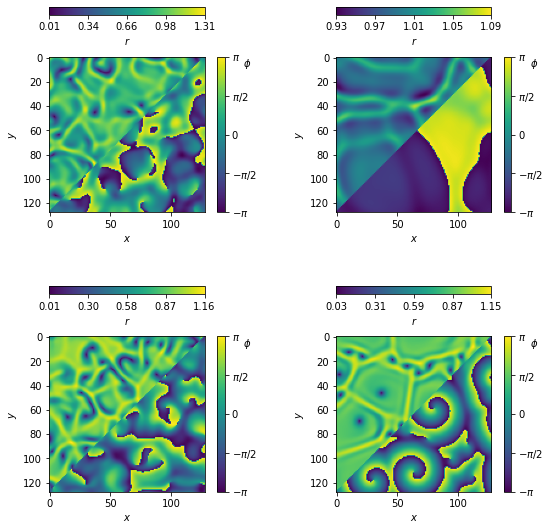

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig=plt.subplots(2,2,figsize=(8,8))
plt.subplots_adjust(wspace=0.8, hspace=0.8)

for i in range(len(xs)):
    plt.subplot(2,2,i+1)
    amp=np.sqrt(xs[i][:,:,-1,0]**2+xs[i][:,:,-1,1]**2)
    phase=(np.arctan2(xs[i][:,:,-1,0],xs[i][:,:,-1,1]))
    ampmax=np.max(amp)
    ampmin=np.min(amp)
    phasemax=np.pi
    phasemin=-np.pi
    test=np.triu(phase-phasemin)/(phasemax-phasemin)+np.tril(amp-ampmin,k=-1)/(ampmax-ampmin)
    fig=plt.imshow(np.flip(test,axis=0),vmin=0,vmax=1)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    ax=plt.gca()
    axins = inset_axes(ax,
                        width="100%",  
                        height="5%",
                        loc='upper center',
                        borderpad=-5
                       )
    cbar=plt.colorbar(cax=axins, orientation="horizontal",ticks=[0,0.25,0.5,0.75,1.0],label='$r$')
    cbar.ax.set_xticklabels(['%.2f'%(ampmin+i/4*(ampmax-ampmin))for i in range(5)])  

    axins2 = inset_axes(ax,
                        width="5%",  
                        height="100%",
                        loc='right',
                        borderpad=-2
                       )
    cbar2=plt.colorbar(cax=axins2, orientation="vertical",ticks=[0,0.25,0.5,0.75,1.0],label='$\phi$')
    cbar2.ax.set_yticklabels(['$-\pi$','$-\pi/2$',0,'$\pi/2$','$\pi$'])  
    cbar2.set_label('$\phi$',loc='top',rotation=0,labelpad=-5)
    
plt.show()


Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [12]:
start=timeit.default_timer()
lib=ps.PDELibrary(library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x],derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,  lambda x,y:x+y+y],periodic=True)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['X', 'Y'])
model.fit(xs[-1],t=dt)
model.print()
stop=timeit.default_timer()
print(stop-start)

(X)' = 0.995 X + -0.984 XXX + -0.753 YYY + -0.753 XXY + -0.984 XYY + 1.044 X_22 + -1.025 Y_22 + 1.044 X_11 + -1.024 Y_11
(Y)' = 0.995 Y + 0.753 XXX + -0.984 YYY + -0.984 XXY + 0.754 XYY + 1.025 X_22 + 1.043 Y_22 + 1.024 X_11 + 1.042 Y_11
4.358013901999996


Try a SINDy model with multiple trajectories using the PDELibrary or WeakPDELibrary applied to both the input features xs and the control features us. To keep the number of output features reasonable but include all needed terms, we concatenate one library with include_interactions=True with another with include_interactions=False. Note that the spatial derivatives of the control features vanish, and there are many undesirable features. The fit is slow.

In [13]:
start=timeit.default_timer()
library_functions=[lambda x:x]
function_names=[lambda x:x]
lib1=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=True, function_names=function_names,periodic=True,include_bias=True)
library_functions=[lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x, lambda x,y: x**3*y, lambda x,y: x*y**3, lambda x,y,z: x*y*z**2,lambda x,y,z: x*y**2*z,lambda x,y,z: x**2*y*z, lambda x,y: x**2*y**2, lambda x:x**4]
function_names=[lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y,lambda x,y:x+x+x+y,lambda x,y:x+y+y+y,lambda x,y,z:x+y+z+z,lambda x,y,z:x+y+y+z,lambda x,y,z:x+x+y+z,lambda x,y:x+x+y+y, lambda x:x+x+x+x]
lib2=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,periodic=True)
lib=lib1+lib2
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['u', 'v', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['u', 'v', 'b', 'c']))

(u)' = 203918834.454 u + 1.038 u_22 + 1.036 u_11 + -1.029 cv_1 + -1.026 bv_12 + -0.989 uuu + -0.989 uvv + -356857958.551 ubb + -1.001 vvvc + 152939125.093 ubbb + -1.002 uuvc
(v)' = 1930717414.656 v + 1.037 v_22 + 1.037 v_11 + 1.028 cu_1 + 1.027 bu_12 + -0.989 vvv + -0.989 uuv + -3378755473.904 vbb + 1.001 uuuc + 1448038060.244 vbbb + 1.001 uvvc
859.475772366
['1', 'u', 'v', 'b', 'c', 'u_2', 'v_2', 'b_2', 'c_2', 'u_22', 'v_22', 'b_22', 'c_22', 'u_1', 'v_1', 'b_1', 'c_1', 'u_12', 'v_12', 'b_12', 'c_12', 'u_11', 'v_11', 'b_11', 'c_11', 'uu_2', 'uv_2', 'ub_2', 'uc_2', 'vu_2', 'vv_2', 'vb_2', 'vc_2', 'bu_2', 'bv_2', 'bb_2', 'bc_2', 'cu_2', 'cv_2', 'cb_2', 'cc_2', 'uu_22', 'uv_22', 'ub_22', 'uc_22', 'vu_22', 'vv_22', 'vb_22', 'vc_22', 'bu_22', 'bv_22', 'bb_22', 'bc_22', 'cu_22', 'cv_22', 'cb_22', 'cc_22', 'uu_1', 'uv_1', 'ub_1', 'uc_1', 'vu_1', 'vv_1', 'vb_1', 'vc_1', 'bu_1', 'bv_1', 'bb_1', 'bc_1', 'cu_1', 'cv_1', 'cb_1', 'cc_1', 'uu_12', 'uv_12', 'ub_12', 'uc_12', 'vu_12', 'vv_12', 'vb_12'

In [4]:
start=timeit.default_timer()
library_functions=[lambda x:x]
function_names=[lambda x:x+' ']
np.random.seed(100)
lib1=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=True, function_names=function_names,periodic=True,include_bias=True)
library_functions=[lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x, lambda x,y: x**3*y, lambda x,y: x*y**3, lambda x,y,z: x*y*z**2,lambda x,y,z: x*y**2*z,lambda x,y,z: x**2*y*z, lambda x,y: x**2*y**2, lambda x:x**4]
function_names=[lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y,lambda x,y:x+x+x+y,lambda x,y:x+y+y+y,lambda x,y,z:x+y+z+z,lambda x,y,z:x+y+y+z,lambda x,y,z:x+x+y+z,lambda x,y:x+x+y+y, lambda x:x+x+x+x]
np.random.seed(100)
lib2=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=0,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,periodic=True)
lib=lib1+lib2
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['u', 'v', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(u)' = 0.780 u  + 0.999 u_22 + 1.001 u_11 + -1.035 b v_22 + -1.029 b v_11 + -0.995 uuu + -0.994 uvv + 0.377 ubb + -1.002 vvvc + -0.161 ubbb + -1.000 uuvc
(v)' = 0.779 v  + 0.998 v_22 + 1.002 v_11 + 1.030 b u_22 + 1.035 b u_11 + -0.993 vvv + -0.991 uuv + 0.376 vbb + 1.002 uuuc + -0.161 vbbb + 1.000 uvvc
16.188720227999998
['1', 'x ', 'y ', 'b ', 'c ', 'x_2', 'y_2', 'b_2', 'c_2', 'x_22', 'y_22', 'b_22', 'c_22', 'x_1', 'y_1', 'b_1', 'c_1', 'x_12', 'y_12', 'b_12', 'c_12', 'x_11', 'y_11', 'b_11', 'c_11', 'x x_2', 'y x_2', 'b x_2', 'c x_2', 'x y_2', 'y y_2', 'b y_2', 'c y_2', 'x b_2', 'y b_2', 'b b_2', 'c b_2', 'x c_2', 'y c_2', 'b c_2', 'c c_2', 'x x_22', 'y x_22', 'b x_22', 'c x_22', 'x y_22', 'y y_22', 'b y_22', 'c y_22', 'x b_22', 'y b_22', 'b b_22', 'c b_22', 'x c_22', 'y c_22', 'b c_22', 'c c_22', 'x x_1', 'y x_1', 'b x_1', 'c x_1', 'x y_1', 'y y_1', 'b y_1', 'c y_1', 'x b_1', 'y b_1', 'b b_1', 'c b_1', 'x c_1', 'y c_1', 'b c_1', 'c c_1', 'x x_12', 'y x_12', 'b x_12', 'c x_12', 'x y_12

Try a SINDy model with multiple trajectories using the ParameterizedLibrary. Use a PDELibrary for the feature_library with second-order derivatives and library functions that include the relevant cubic term. Use a PDELibrary for the parameter_library with zeroth-order derivatives and linear library functions. The fit is very good!

In [15]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names,periodic=True)
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,periodic=True,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 0.996 1 x + -0.993 1 xxx + -0.993 1 xyy + 1.035 1 x_22 + 1.033 1 x_11 + -1.031 b y_22 + -1.028 b y_11 + -1.002 c yyy + -1.002 c xxy
(y)' = 0.996 1 y + -0.993 1 yyy + -0.993 1 xxy + 1.033 1 y_22 + 1.033 1 y_11 + 1.030 b x_22 + 1.029 b x_11 + 1.002 c xxx + 1.001 c xyy
73.72480362999988
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


If we ensure the same domain cells are used in the feature library and the parameter library (by reseeding np.random), the WeakLibrary can be used with the ParameterLibrary. (In this case, the parameters need to be constants, so that the tensor product of two WeakLibrary corresponds to the correct weak features.) The fit is perfect and super fast!

In [5]:
start=timeit.default_timer()
np.random.seed(100)
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,periodic=True)
np.random.seed(100)
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,periodic=True,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 1.000 1 x + -1.000 1 xxx + -1.000 1 xyy + 1.000 1 x_22 + 1.000 1 x_11 + -1.000 b y_22 + -1.000 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 1.000 1 y + -1.000 1 yyy + -1.000 1 xxy + 1.000 1 y_22 + 1.000 1 y_11 + 1.000 b x_22 + 1.000 b x_11 + 1.000 c xxx + 1.000 c xyy
2.8242021789999967
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


### TODO: Simulate and discover several model parameterized equations. Include the logistic map & a reaction-diffusion system.

### Higher-order parameter libraries will work with more trajectories

In [ ]:
bs=np.random.normal(1.5,0.5,size=10)
cs=np.random.normal(1.0,0.25,size=10)
scales=[1e-1]*5+[1e0]*5

xs=[]
for i in range(len(bs)):
    b=bs[i]
    c=cs[i]
    scale0=scales[i]
    start=timeit.default_timer()

    ks=np.arange(-2,3)
    phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
    np.random.seed(100)
    for kx in ks:
        for ky in ks:
            if not (kx==0 and ky==0):
                scale=scale0/(kx**2+ky**2)**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 
    
    phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
    phase=phase_init.reshape(N)
    times=[]
    dt1=dt/1000
    for n in range(int(t1/dt)):
        t=n*dt
        print('%.1f'%(t),end='\r')
        sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
        times.append(sol.t)
        dt1=np.mean(np.diff(sol.t))
        phase=sol.y[:,-1]
        phases[n] = phase

    stop=timeit.default_timer()
    print(stop-start)
    x=np.zeros((nx,ny,nt,2))
    x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    xs.append(x)
    
#Create list of control inputs corresponding to the parameters. 
#The control inputs have the same shape as the data, 
#but are constant across the spatiotemporal grid.
us=[]
for i in range(len(xs)):
    b=bs[i]
    c=cs[i]
    u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
    u[:,:,:,0]=b
    u[:,:,:,1]=c
    us.append(u)

In [ ]:
spatiotemporal_grid=np.zeros((nx,ny,100,3))
spatiotemporal_grid[:,:,:,:2]=spatial_grid[:,:,np.newaxis,:]
spatiotemporal_grid[:,:,:,2]=dt*np.arange(100)

start=timeit.default_timer()
np.random.seed(100)
library_functions=[lambda x:x, lambda x:x**2, lambda x,y: x*y, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x: x+x, lambda x,y: x+y, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,periodic=True)
np.random.seed(100)
library_functions=[lambda x:x, lambda x:x**2, lambda x,y:x*y, lambda x: x**3, lambda x,y: x**2*y, lambda x,y: x*y**2]
function_names=[lambda x:x, lambda x:x+x, lambda x,y:x+y, lambda x:x+x+x, lambda x,y: x+x+y, lambda x,y: x+y+y]
parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,periodic=True,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))